## Introduction
Supermarket chain Good Seed is introducing a computer vision system for processing customer photos.  The company wants to test the feasibility of using photos taken at checkout to determine whether customers are old enough to purchase alcohol.  In this project, build a neural network model to estimate the customer's age from a photo.

## Load Data
In this section, we will load the labels (customer ages) and photos for each customer.

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Labels

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### Photos

We will use the `labels` dataframe to generate batches of images.

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
    labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    class_mode='raw',
    batch_size=32,
    seed=54321
)

Found 7591 validated image filenames.


In [20]:
features, target = next(train_datagen_flow)

In [23]:
features.shape

(32, 150, 150, 3)

Each batch is a four-dimensional tensor with 32 150x150 images with three color channels.

## EDA

### Labels

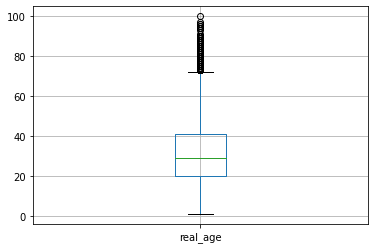

In [6]:
labels.boxplot();

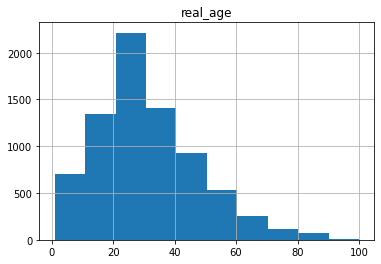

In [8]:
labels.hist();

In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Images

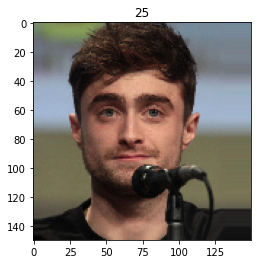

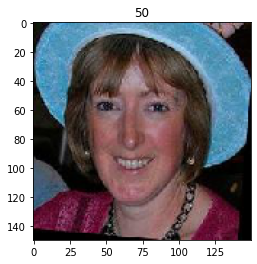

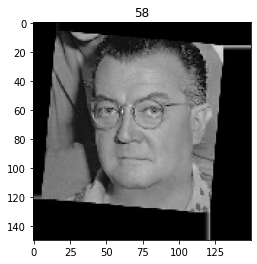

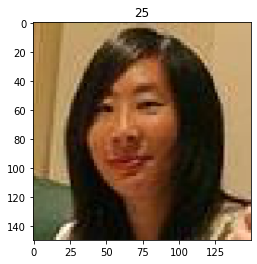

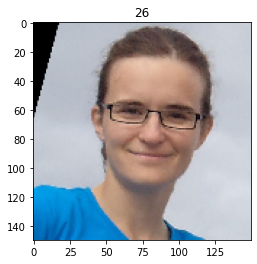

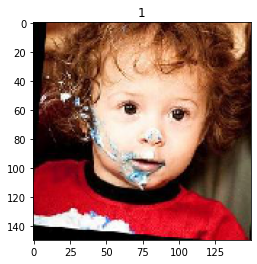

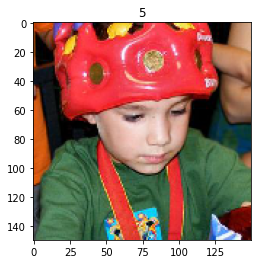

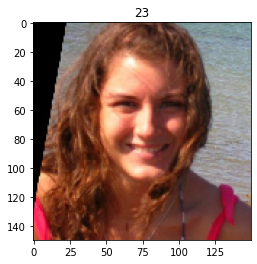

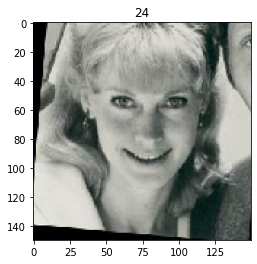

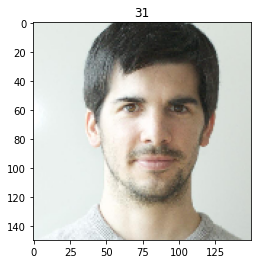

In [31]:
for age, image in zip(target[:10], features[:10]):
    plt.figure()
    plt.title(age)
    plt.imshow(image)

### Findings

- The dataset includes 7,591 images.
- Ages range from 1 to 100.
- The mean age is 31 years.
- The distribution is skewed slightly to the right, with some high-age outliers.
- Age labels appear to match the images.

## Modelling
- The code below was run on a GPU.  It is not intended to be run in the Jupyter notebook.
- The ResNet50 architecture was used as the starting point for the model.
- The data was augmented by horizontal flipping.
- The Adam optimizer was used, with a learning rate of 0.0001.  

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1.0/255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=32,
        subset='training',
        seed=54321
    )
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                      rescale=1.0/255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=32,
        subset='validation',
        seed=54321
    )
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mae'])    
    return model


def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=10,
                steps_per_epoch=None, 
                validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

### Output
Below is the output from training the model on the GPU.

`Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 122s - loss: 320.0644 - mae: 12.8271 - val_loss: 1119.3525 - val_mae: 28.8697
Epoch 2/10
178/178 - 35s - loss: 86.0497 - mae: 6.9843 - val_loss: 721.1080 - val_mae: 21.5788
Epoch 3/10
178/178 - 35s - loss: 58.8798 - mae: 5.8289 - val_loss: 332.3872 - val_mae: 13.7216
Epoch 4/10
178/178 - 35s - loss: 39.6732 - mae: 4.7863 - val_loss: 157.9239 - val_mae: 9.2353
Epoch 5/10
178/178 - 35s - loss: 29.0633 - mae: 4.0757 - val_loss: 96.6769 - val_mae: 7.3909
Epoch 6/10
178/178 - 35s - loss: 21.0352 - mae: 3.4896 - val_loss: 73.5241 - val_mae: 6.4846
Epoch 7/10
178/178 - 35s - loss: 15.7085 - mae: 3.0386 - val_loss: 82.3471 - val_mae: 7.0538
Epoch 8/10
178/178 - 35s - loss: 12.0535 - mae: 2.6105 - val_loss: 72.9516 - val_mae: 6.3708
Epoch 9/10
178/178 - 35s - loss: 9.2347 - mae: 2.3078 - val_loss: 70.8815 - val_mae: 6.2862
Epoch 10/10
178/178 - 35s - loss: 8.2814 - mae: 2.1563 - val_loss: 67.8192 - val_mae: 6.1488
60/60 - 9s - loss: 67.8192 - mae: 6.1488
Test MAE: 6.1488`

## Conclusions

- The mean absolute error for the validation set was 6.1488, which exceeds the benchmark of <7.
- By the 10th epoch of training, MAE was still decreasing.  It is likely that a further reduction in MAE would be achieved if the number of epochs were increased.
- Good Seed could use the results of this study to set an age below which a manual ID check is required for alcohol purchase.
- Other potential uses of this technology would be to target ads or give coupons based on products that would be of interest based on customer's age group.